In [2]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

# EDA

In [ ]:
data_path = "../../data/"

train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
dev_df = pd.read_csv(os.path.join(data_path, "dev.csv"))

train_df.head(1)
dev_df.head(1)

,fname,dialogue,summary,topic
0,dev_0,"#Person1#: 안녕하세요, 오늘 기분이 어떠세요?\n#Person2#: 요즘 ...",#Person2#는 숨쉬기 어려워합니다. 의사는 #Person2#에게 증상을 확인하...,의사 상담


## 마스킹 종류 및 개수 파악

In [4]:
def reg_masking(text):
  pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
  masked = re.findall(pattern, text)
  return masked

train_masking = train_df["dialogue"].apply(lambda x: str(set(reg_masking(x))))
dev_masking = dev_df["dialogue"].apply(lambda x: str(set(reg_masking(x))))

train_masking = train_masking.value_counts().reset_index().rename(columns = {"dialogue": "mask"})
display(train_masking)


,mask,count
0,"{'#Person2#', '#Person1#'}",12074
1,"{'#PhoneNumber#', '#Person2#', '#Person1#'}",127
2,"{'#Person2#', '#Person1#', '#Person3#'}",105
3,"{'#Person2#', '#Person1#', '#Address#'}",59
4,"{'#DateOfBirth#', '#Person2#', '#Person1#'}",13
5,"{'#PhoneNumber#', '#Person2#', '#Person1#', '#...",11
6,"{'#Person4#', '#Person2#', '#Person1#', '#Pers...",10
7,"{'#Person2#', '#Person1#', '#Email#'}",8
8,"{'#Person2#', '#Person1#', '#CardNumber#'}",8
9,"{'#Person2#', '#Person1#', '#CarNumber#'}",4


In [5]:
import ast

uniques = train_masking["mask"].apply(lambda x: ast.literal_eval(x))
unique_mask = set.union(*uniques)
unique_mask



{'#Address#',
 '#Alex#',
 '#Bob#',
 '#CarNumber#',
 '#CardNumber#',
 '#DateOfBirth#',
 '#Email#',
 '#Kristin#',
 '#Liliana#',
 '#Name#',
 '#PassportNumber#',
 '#Person1#',
 '#Person2#',
 '#Person3#',
 '#Person4#',
 '#Person5#',
 '#Person6#',
 '#Person7#',
 '#PersonName#',
 '#PhoneNumber#',
 '#Price#',
 '#SSN#'}

## 문장 길이 분포 확인

In [40]:
train_df['text_length_dialogue'] = train_df['dialogue'].apply(lambda x: len(x.split()))
train_df['text_length_summary'] = train_df['summary'].apply(lambda x: len(x.split()))
train_df['compression_ratio'] = train_df['text_length_summary'] / train_df['text_length_dialogue']

display(train_df['text_length_dialogue'].describe())
display(train_df['text_length_summary'].describe())
display(train_df['compression_ratio'].describe())

count    12457.000000
mean        84.464478
std         43.613074
min         17.000000
25%         56.000000
50%         75.000000
75%        106.000000
max        508.000000
Name: text_length_dialogue, dtype: float64

count    12457.000000
mean        16.480694
std          7.015613
min          4.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         75.000000
Name: text_length_summary, dtype: float64

count    12457.000000
mean         0.213563
std          0.076621
min          0.052632
25%          0.163934
50%          0.200000
75%          0.245614
max          0.800000
Name: compression_ratio, dtype: float64

### 압축률 기준 상하위 샘플 확인

In [43]:
train_df_comp = train_df.sort_values(by="compression_ratio", ascending=False)
n = 15
print(f"----------------상위 {n}개 데이터----------------")
for i in range(n):
  print(f"원문[{i}] {train_df_comp.iloc[i]['dialogue']}")
  print(f"요약문[{i}] {train_df_comp.iloc[i]['summary']}")
  print(f"압축률[{i}] {train_df_comp.iloc[i]['compression_ratio']}")
  print("-"*100)

print(f"----------------하위 {n}개 데이터----------------")
for i in range(n):
  print(f"원문[{i}] {train_df_comp.iloc[-i-1]['dialogue']}")
  print(f"요약문[{i}] {train_df_comp.iloc[-i-1]['summary']}")
  print(f"압축률[{i}] {train_df_comp.iloc[-i-1]['compression_ratio']}")
  print("-"*100)

----------------상위 15개 데이터----------------
원문[0] #Person1#: 여덟 명을 위해 저녁을 준비했는데 Mary가 전화해서 그녀와 남편이 못 온다고 했어. 
#Person2#: 괜찮아. 내가 Tom이랑 그의 여자친구를 초대했거든.
요약문[0] #Person1#은 Mary와 그녀의 남편이 저녁 식사에 참석하지 못한다고 들었고, #Person2#는 Tom과 그의 여자친구를 대신 초대했다고 전한다.
압축률[0] 0.8
----------------------------------------------------------------------------------------------------
원문[1] #Person1#: 우리 런던에 있으면 신문사에서 일하거나 분필 먼지 가득한 교실에서 가르치게 되겠지.
#Person2#: 글쎄, 톰, 넌 때때로 햇볕 쬐러 나갈 수도 있겠지. 너는 기자니까. 나는 교실에 있어야 해. 기억해.
요약문[1] Tom은 자신과 #Person2#가 런던에 있는 동안 실내에서 일하게 될 것이라고 말합니다. #Person2#는 Tom이 기자로서 밖에 나갈 수 있지만 본인은 교실에서 가르쳐야 한다고 언급합니다.
압축률[1] 0.7931034482758621
----------------------------------------------------------------------------------------------------
원문[2] #Person1#: 나 새로 나온 티셔츠 하나 살까 생각 중이야, 앞뒤로 학교 로고 있는 거 말이야.
#Person2#: 후회할걸. 그거 비싸고, 빨면 인쇄가 금방 바랜다고 하더라.
요약문[2] #Person1#는 학교 로고가 있는 새로 나온 티셔츠를 구매할 계획입니다. #Person2#는 그것이 비싸고 인쇄가 빨리 바래므로 #Person1#이 후회할 것이라고 주장합니다.
압축률[2] 0.7916666666666666
--------------------------

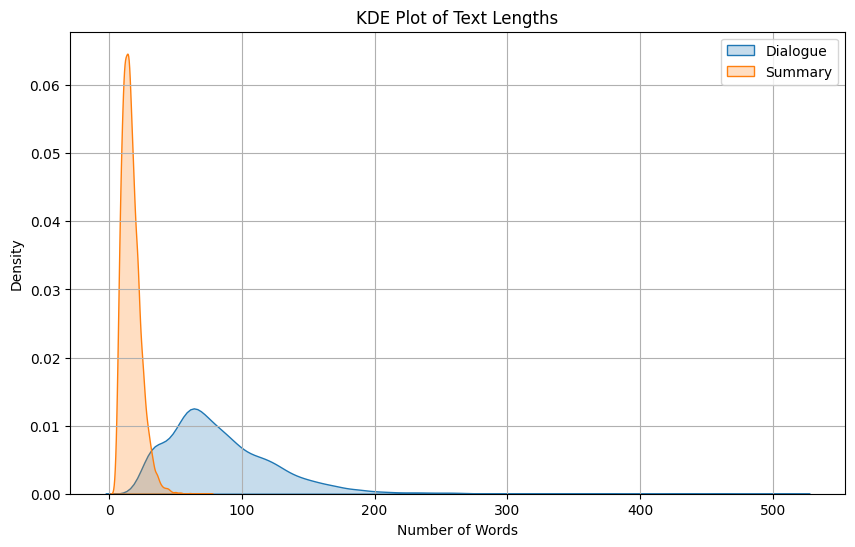

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.kdeplot(train_df['text_length_dialogue'], label='Dialogue', fill=True)
sns.kdeplot(train_df['text_length_summary'], label='Summary', fill=True)

plt.title("KDE Plot of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


1. 입력 대비 출력 길이 차이 큼
- 요약은 평균적으로 대화 길이의 1/3 이하

→ Text Summarization 모델의 압축률이 높음 적절한 max_input_length, max_target_length 설정 필요

2. 요약문은 길이 편차가 적음
- 모델 출력 길이에 대한 길이 조절(LenPen, min_length, max_length 등) 전략이 효과적일 수 있음

3. Padding 효율 고려 가능
- 요약 길이는 대부분 짧아서 batch 단위 padding 시 낭비 적음

- Dialogue는 길이 편차 크므로 padding 최적화 필요 (→ bucketing 전략 고려)

| 항목            | 전략                                                            |
| ------------- | ------------------------------------------------------------- |
| Tokenizer 세팅  | `max_input_length`는 384~512, `max_target_length`는 64~~128 추천 |
| Generation 설정 | `min_length`, `max_length`, `length_penalty` 세심하게 조정 필요       |
| Batching 전략   | Dialogue 길이에 따라 bucketing 또는 dynamic padding 활용               |
| 모델 선택         | 긴 컨텍스트 처리에 강한 모델(BART-large, PEGASUS 등) 유리                    |


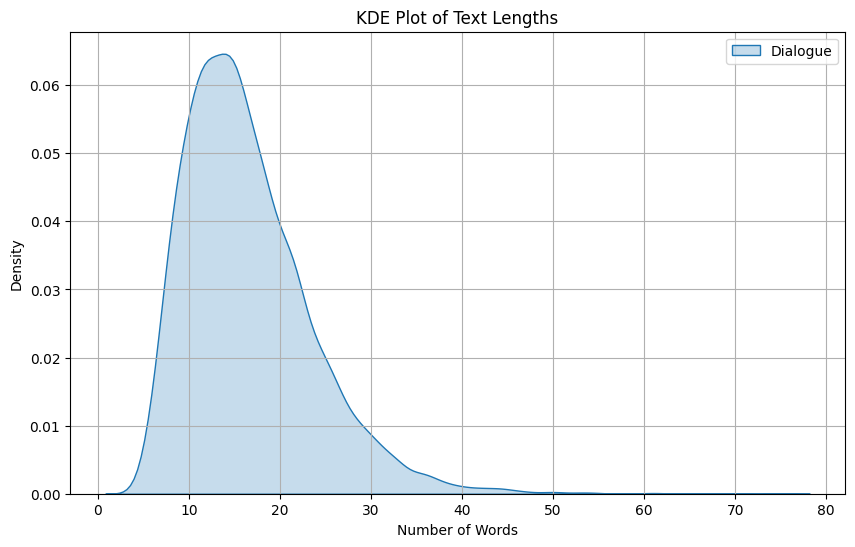

In [8]:
plt.figure(figsize=(10, 6))

sns.kdeplot(train_df['text_length_summary'], label='Dialogue', fill=True)

plt.title("KDE Plot of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## 요약문이 원문에서 등장한 단어 비율(등장하지 않은 비율도)

In [31]:
import string
from konlpy.tag import Okt

# 형태소 분석기
okt = Okt()

# 알파벳 치환용 문자 리스트
ALPHABET = list(string.ascii_uppercase)

stop_words_path = "../data/stopwords-ko.txt"

with open(stop_words_path, "r", encoding="utf-8") as f:
    stop_words_ko = set([line.strip() for line in f])


# 전처리 함수
def preprocess_ko(text):
    # 1. 소문자 변환 (영어 혼용시 유용)
    # 특수 토큰(#Person1# 같은 것)을 따로 추출
    special_tokens = set(re.findall(r"#\w+#", text))  # 예: #Person1#

    token_map = {f"SPECIAL{ALPHABET[i]}": token for i, token in enumerate(special_tokens)}

    # 3. 치환
    for key, token in token_map.items():
        text = text.replace(token, key)

    # 2. 구두점 제거
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. 형태소 분석 및 불용어 제거
    words = okt.morphs(text, stem=True)

    words = [word for word in words if word not in stop_words_ko and word.strip()]

    # 다시 특수 토큰 복원
    for key, token in token_map.items():
        words = [token if t==key else t for t in words]

    return words

def calculate_coverage_ratio(dialogue: str, summary: str) -> float:
    # 전처리된 단어 리스트
    dialogue_tokens = set(preprocess_ko(dialogue))  # 중복 제거
    summary_tokens = preprocess_ko(summary)

    if not summary_tokens:
        return 0.0

    # 요약문 단어 중 원문에도 존재하는 것만 필터링
    overlap = [word for word in summary_tokens if word in dialogue_tokens]
    nonoverlap = [word for word in summary_tokens if word not in dialogue_tokens]
    overlap_ratio = len(overlap) / len(summary_tokens)
    nonoverlap_ratio = len(nonoverlap) / len(summary_tokens)

    return overlap_ratio, nonoverlap_ratio


In [33]:
train_df[['coverage_ratio', 'noncoverage_ratio']] = train_df.apply(
    lambda row: pd.Series(calculate_coverage_ratio(row['dialogue'], row['summary'])),
    axis=1
)

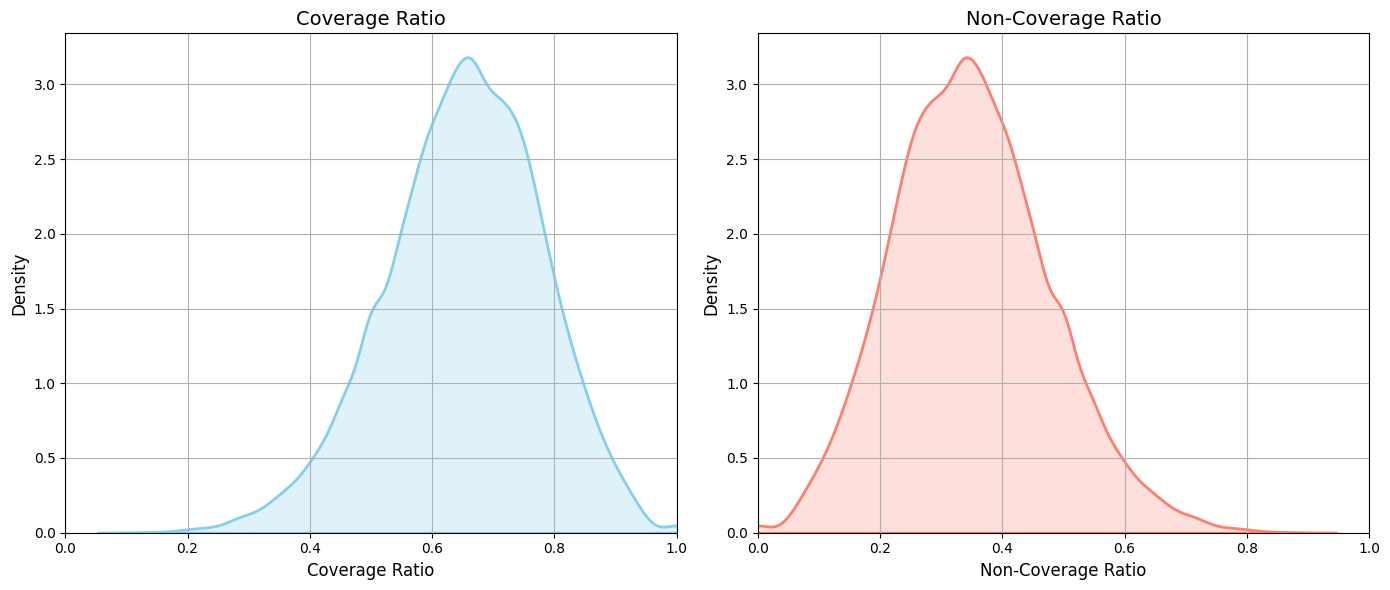

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))  # 가로 넓게

# subplot 1: coverage_ratio
plt.subplot(1, 2, 1)
sns.kdeplot(train_df['coverage_ratio'], fill=True, color='skyblue', linewidth=2)
plt.title("Coverage Ratio", fontsize=14)
plt.xlabel("Coverage Ratio", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True)
plt.xlim(0, 1)

# subplot 2: noncoverage_ratio
plt.subplot(1, 2, 2)
sns.kdeplot(train_df['noncoverage_ratio'], fill=True, color='salmon', linewidth=2)
plt.title("Non-Coverage Ratio", fontsize=14)
plt.xlabel("Non-Coverage Ratio", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(True)
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


### 커버리지 기준 상하위 5개 샘플 확인

In [44]:
train_df_sorted = train_df.sort_values(by="coverage_ratio", ascending=False)
n = 15
print(f"----------------상위 {n}개 데이터----------------")
for i in range(n):
  print(f"원문[{i}] {train_df_sorted.iloc[i]['dialogue']}")
  print(f"요약문[{i}] {train_df_sorted.iloc[i]['summary']}")
  print(f"커버리지 비율[{i}] {train_df_sorted.iloc[i]['coverage_ratio']}")
  print(f"비커버리지 비율[{i}] {train_df_sorted.iloc[i]['noncoverage_ratio']}")
  print("-"*100)

print(f"----------------하위 {n}개 데이터----------------")
for i in range(n):
  print(f"원문[{i}] {train_df_sorted.iloc[-i-1]['dialogue']}")
  print(f"요약문[{i}] {train_df_sorted.iloc[-i-1]['summary']}")
  print(f"커버리지 비율[{i}] {train_df_sorted.iloc[-i-1]['coverage_ratio']}")
  print(f"비커버리지 비율[{i}] {train_df_sorted.iloc[-i-1]['noncoverage_ratio']}")
  print("-"*100)

----------------상위 15개 데이터----------------
원문[0] #Person1#: 안녕하세요, 여기는 버드의 자전거 대여점입니다. 
#Person2#: 안녕하세요. 친구가 자전거 빌리려고 여기 전화하라고 하던데요. 
#Person1#: 아, 네. 요즘 많은 분들이 그러세요. 
#Person2#: 네, 저희가 며칠 동안 휴가를 보내고 있는 중인데, 자전거로 섬을 둘러보는 게 좋다고 하더라고요. 
#Person1#: 그럼요, 맞아요. 대부분의 분들은 오토바이도 빌리시는데요, 그러면 더 빨리 다닐 수 있고, 원한다면 해변에도 갈 수 있어요. 
#Person2#: 만약에 내일 아침에 오토바이 두 대를 이틀 간 빌리고 싶은데 문제가 있을까요? 
#Person1#: 전혀 문제 없습니다. 이름 좀 알려주실래요? 
#Person2#: 그린이에요, 아서 그린. 
#Person1#: 그럼 전화번호는요? 
#Person2#: 지금 홀리데이 선 호텔에 있어요. 제 번호는 #PhoneNumber#입니다. 1203호에 있고요. 그런데 바이크 대여점이 테컴 스트리트 100번지 맞나요? 
#Person1#: 맞아요. 
#Person2#: 감사합니다. 안녕히 계세요.
요약문[0] 아서 그린은 버드의 자전거 대여점에 전화하여 내일 아침 오토바이 두 대를 이틀 동안 빌리려 합니다.
커버리지 비율[0] 1.0
비커버리지 비율[0] 0.0
----------------------------------------------------------------------------------------------------
원문[1] #Person1#: 하드웨어 관련 책 좀 필요해요.
#Person2#: 여기 책이 많은데, 이것들은 어때요?
#Person1#: 좋아요! 바로 제가 원하던 책들이에요. 두 권 빌려도 될까요?
#Person2#: 물론이죠. 그런데 일주일 동안만 빌릴 수 있어요.
#Person1#: 알겠어요. 고마워요.
요약문[1] #Person1#은 하드웨어 관련 책

### 토픽별 coverage 비율 확인

In [39]:
topic_coverage_mean = (
    train_df.groupby("topic")["coverage_ratio"]
    .mean()
    .reset_index()
    .sort_values(by="coverage_ratio", ascending=False)
)

display(topic_coverage_mean)

,topic,coverage_ratio
3764,소개,1.000000
2377,무료 서비스 제공,1.000000
1004,교통 위반,1.000000
3155,빨래 방안,1.000000
7616,출구 찾기,1.000000
...,...,...
6979,지각 사과,0.181818
3773,소문과 최근 소식,0.176471
3413,새 자동차 구입,0.153846
4122,스토킹으로 인한 두려움과 사랑,0.142857


| 항목      | 분석 결과                            | 해석                       |
| ------- | -------------------------------- | ------------------------ |
| 커버리지 중심 | 0.6\~0.7                         | 대부분 원문 단어 60\~70% 재사용    |
| 분포 모양   | 한쪽 치우침 없는 종형                     | 다양하지만 완전생성/복사 모두 드뭄      |
| 모델 선택 시 | extractive + abstractive 혼합형에 적합 | ex. BART, Pegasus, T5 계열 |
| 데이터 전처리 | 원문-요약 간 정보 중복 고려 필요              | 모델이 복사만 하지 않도록 주의        |


In [46]:
train_df.to_csv("../data/train_eda.csv", index=False)